In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import randint
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor
import pickle

### Import and Preprocessing of the Data
-> not really important for the Webapp

We map the Neighbourhood to the Arrondissement, since this is what we are predicting the price on

In [2]:
Paris=pd.read_csv('/Users/aurelfalch/Library/Mobile Documents/com~apple~CloudDocs/01-Uni/03-Semester/04 Business Analytics und Data Science/Capstone/data/Listing paris_ june.csv')
Paris_cleaned=Paris[['id','host_id','host_response_rate','host_is_superhost',
                    'host_listings_count','host_identity_verified','neighbourhood_cleansed','room_type',
                    'bathrooms_text','bedrooms','amenities','availability_365','reviews_per_month','price']].copy()

Paris_cleaned['price'] = Paris_cleaned['price'].str.replace('$', '').str.replace(',', '').astype(float)
Paris_cleaned['bathrooms_text'] = Paris_cleaned['bathrooms_text'].str.extract('(\d+)').astype(float)
Paris_cleaned['host_is_superhost'] = Paris_cleaned['host_is_superhost'].replace({'t': True, 'f': False}).astype(bool)
Paris_cleaned['host_identity_verified'] = Paris_cleaned['host_identity_verified'].replace({'t': True, 'f': False}).astype(bool)
Paris_cleaned['host_response_rate'] = Paris_cleaned['host_response_rate'].str.rstrip('%').astype('float')



def missing(df):
    return pd.DataFrame({
        'Missing': df.isnull().sum(),
        '%': (df.isnull().sum() / len(df) * 100)})

missing(Paris_cleaned)

,Missing,%
id,0,0.000000
host_id,0,0.000000
host_response_rate,31392,37.346975
host_is_superhost,0,0.000000
host_listings_count,26,0.030932
host_identity_verified,0,0.000000
neighbourhood_cleansed,0,0.000000
room_type,0,0.000000
bathrooms_text,545,0.648385
bedrooms,7137,8.490869


In [3]:

quartier_to_arrondissement = {
    # 1er arrondissement
    'St-Germain-l\'Auxerrois': '1er',
    'Halles': '1er',
    'Palais-Royal': '1er',
    'Place-Vendôme': '1er',

    # 2e arrondissement
    'Gaillon': '2e',
    'Vivienne': '2e',
    'Mail': '2e',
    'Bonne-Nouvelle': '2e',

    # 3e arrondissement
    'Arts-et-Metiers': '3e',
    'Enfants-Rouges': '3e',
    'Archives': '3e',
    'Sainte-Avoie': '3e',

    # 4e arrondissement
    'Saint-Merri': '4e',
    'Saint-Gervais': '4e',
    'Arsenal': '4e',
    'Notre-Dame': '4e',

    # 5e arrondissement
    'Saint-Victor': '5e',
    'Jardin-des-Plantes': '5e',
    'Val-de-Grace': '5e',
    'Sorbonne': '5e',

    # 6e arrondissement
    'Monnaie': '6e',
    'Odeon': '6e',
    'Notre-Dame-des-Champs': '6e',
    'Saint-Germain-des-Prés': '6e',

    # 7e arrondissement
    'Saint-Thomas-d\'Aquin': '7e',
    'Invalides': '7e',
    'Ecole-Militaire': '7e',
    'Gros-Caillou': '7e',

    # 8e arrondissement
    'Champs-Elysées': '8e',
    'Faubourg-du-Roule': '8e',
    'Madeleine': '8e',
    'Europe': '8e',

    # 9e arrondissement
    'Saint-Georges': '9e',
    'Chaussée-d\'Antin': '9e',
    'Faubourg-Montmartre': '9e',
    'Rochechouart': '9e',

    # 10e arrondissement
    'Saint-Vincent-de-Paul': '10e',
    'Porte-Saint-Denis': '10e',
    'Porte-Saint-Martin': '10e',
    'Hôpital-Saint-Louis': '10e',

    # 11e arrondissement
    'Folie-Méricourt': '11e',
    'Saint-Ambroise': '11e',
    'Roquette': '11e',
    'Sainte-Marguerite': '11e',

    # 12e arrondissement
    'Bercy': '12e',
    'Quinze-Vingts': '12e',
    'Bel-Air': '12e',
    'Picpus': '12e',

    # 13e arrondissement
    'Salpêtrière': '13e',
    'Gare': '13e',
    'Maison-Blanche': '13e',
    'Croulebarbe': '13e',

    # 14e arrondissement
    'Montparnasse': '14e',
    'Parc-de-Montsouris': '14e',
    'Petit-Montrouge': '14e',
    'Plaisance': '14e',

    # 15e arrondissement
    'Grenelle': '15e',
    'Necker': '15e',
    'Saint-Lambert': '15e',
    'Javel 15Art': '15e',

    # 16e arrondissement
    'Auteuil': '16e',
    'Muette': '16e',
    'Porte-Dauphine': '16e',
    'Chaillot': '16e',

    # 17e arrondissement
    'Ternes': '17e',
    'Plaine de Monceaux': '17e',
    'Batignolles': '17e',
    'Epinettes': '17e',

    # 18e arrondissement
    'Grandes-Carrières': '18e',
    'Clignancourt': '18e',
    'Goutte-d\'Or': '18e',
    'La Chapelle': '18e',

    # 19e arrondissement
    'Villette': '19e',
    'Pont-de-Flandre': '19e',
    'Amérique': '19e',
    'Combat': '19e',

    # 20e arrondissement
    'Belleville': '20e',
    'Saint-Fargeau': '20e',
    'Père-Lachaise': '20e',
    'Charonne': '20e',

    # Second list (already arrondissements - map to themselves)
    'Louvre': '1er',
    'Bourse': '2e',
    'Temple': '3e',
    'Hôtel-de-Ville': '4e',
    'Panthéon': '5e',
    'Luxembourg': '6e',
    'Palais-Bourbon': '7e',
    'Élysée': '8e',
    'Opéra': '9e',
    'Entrepôt': '10e',
    'Popincourt': '11e',
    'Reuilly': '12e',
    'Gobelins': '13e',
    'Observatoire': '14e',
    'Vaugirard': '15e',
    'Passy': '16e',
    'Batignolles-Monceau': '17e',
    'Buttes-Montmartre': '18e',
    'Buttes-Chaumont': '19e',
    'Ménilmontant': '20e'
}


Paris_cleaned['Arrondissement'] = Paris_cleaned['neighbourhood_cleansed'].map(quartier_to_arrondissement)
Paris_cleaned = Paris_cleaned.drop('neighbourhood_cleansed', axis=1)




In [4]:
Paris_cleaned['reviews_per_month'] = Paris_cleaned['reviews_per_month'].fillna(0)
Paris_cleaned = Paris_cleaned[(Paris_cleaned['price'].notna()) & (Paris_cleaned['price'] > 0)].copy()
Paris_cleaned = Paris_cleaned.dropna(subset=['bathrooms_text', 'bedrooms','host_is_superhost',
                                             'host_listings_count','host_identity_verified','host_response_rate'])
missing(Paris_cleaned)


,Missing,%
id,0,0.0
host_id,0,0.0
host_response_rate,0,0.0
host_is_superhost,0,0.0
host_listings_count,0,0.0
host_identity_verified,0,0.0
room_type,0,0.0
bathrooms_text,0,0.0
bedrooms,0,0.0
amenities,0,0.0


Price threshold (lower 2.5th percentile): $50.00
Price threshold (upper 90th percentile): $611.00
Remaining listings: 41393

New price statistics (log-transformed):
count    41393.000000
mean         5.066492
std          0.558775
min          3.931826
25%          4.634729
50%          5.017280
75%          5.463832
max          6.416732
Name: price, dtype: float64


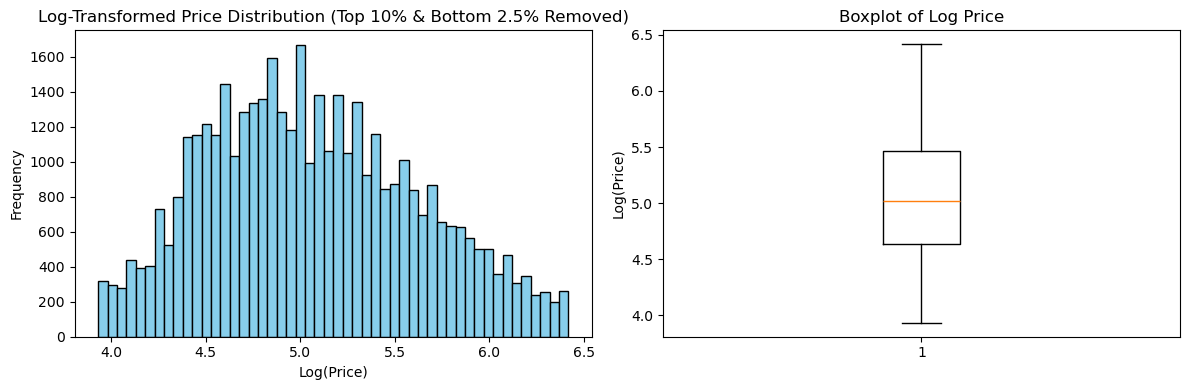

In [5]:
#LOG TRANSFORMATION AND OUTLIERS
# Drop top 5% highest prices and bottom 2.5% lowest prices
price_threshold_upper = Paris_cleaned['price'].quantile(0.95)
price_threshold_lower = Paris_cleaned['price'].quantile(0.025)

Paris_cleaned = Paris_cleaned[
    (Paris_cleaned['price'] >= price_threshold_lower) &
    (Paris_cleaned['price'] <= price_threshold_upper)
]

# Log transform the price
Paris_cleaned['price'] = np.log1p(Paris_cleaned['price'])

print(f"Price threshold (lower 2.5th percentile): ${price_threshold_lower:.2f}")
print(f"Price threshold (upper 90th percentile): ${price_threshold_upper:.2f}")
print(f"Remaining listings: {len(Paris_cleaned)}")
print(f"\nNew price statistics (log-transformed):")
print(Paris_cleaned['price'].describe())

# Quick visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(Paris_cleaned['price'], bins=50, edgecolor='black', color='skyblue')
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.title('Log-Transformed Price Distribution (Top 10% & Bottom 2.5% Removed)')

plt.subplot(1, 2, 2)
plt.boxplot(Paris_cleaned['price'])
plt.ylabel('Log(Price)')
plt.title('Boxplot of Log Price')

plt.tight_layout()
plt.show()
Paris_cleaned = Paris_cleaned.reset_index(drop=True)

### One hot Encoding (Dummy Variables)
In the following code dummy variables for the arrondissement and the roomtype get created.

Further we included dummy variables for the most important amenities (the ones that are the most common and most important in our opinion). Some features get dropped when creating X in the cell below.

So features we need to predict a price for an Airbnb are: (as a list for you to what we need in the webapp)
- host is superhost (bool)
- host listings count (int)
- host identity verfied (bool)
- bathrooms_text (int) -> no. of bathrooms
- bedrooms (int)
- Arrondissement (1 to 20)
- Room_type (Entire home/apt; Hotel room; Private Room; Shared Room)
- Amenities (Kitchen, Wifi, Bathtub, Elevator, Air conditioning, Pets allowed, TV, Private entrance, balcony, City skylinie view)



EDIT: In this new version we create dummy variables for the top 100 amenities and use Recursive Feature Elimination to check which ones are the best. 

In [6]:
# Create one-hot encoding for both CATEGORICAL variables
Paris_encoded = pd.get_dummies(Paris_cleaned,
                               columns=['Arrondissement', 'room_type'],
                               prefix=['Arrondissement', 'room'],
                               drop_first=False)

print(f"Original shape: {Paris_cleaned.shape}")
print(f"Encoded shape: {Paris_encoded.shape}")
print(f"\nNew columns created: {Paris_encoded.shape[1] - Paris_cleaned.shape[1]}")

#print(Paris_encoded.dtypes)

from collections import Counter
import re


# Count frequency of each amenity
amenity_counter = Counter()

for amenities_string in Paris_encoded['amenities']:
    if pd.notna(amenities_string):  # Check if not NaN
        # Split by comma and strip whitespace
        amenities = [a.strip() for a in str(amenities_string).split(',')]
        amenity_counter.update(amenities)

# Get top 30 most common amenities
top100_amenities = amenity_counter.most_common(100)


for amenity, _ in top100_amenities:
    safe_name = re.sub(r'[^0-9a-zA-Z_]', '_', amenity)
    col_name = f"amenity_{safe_name}"
    Paris_encoded[col_name] = Paris_encoded['amenities'].apply(
        lambda x: int(amenity in x) if pd.notna(x) else 0
    )

Paris_encoded = Paris_encoded.copy() #need to do this in order to avoid a error (fragmenting)
display(Paris_encoded.shape)

Original shape: (41393, 14)
Encoded shape: (41393, 36)

New columns created: 22


/var/folders/l2/1w650nzn5z1fcrgnx2w204c40000gn/T/ipykernel_67798/1871948254.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Paris_encoded[col_name] = Paris_encoded['amenities'].apply(
/var/folders/l2/1w650nzn5z1fcrgnx2w204c40000gn/T/ipykernel_67798/1871948254.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Paris_encoded[col_name] = Paris_encoded['amenities'].apply(
/var/folders/l2/1w650nzn5z1fcrgnx2w204c40000gn/T/ipykernel_67798/1871948254.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

(41393, 136)

In [7]:
# Recursive Feature Elemination for checking which Features are the best ones.

from sklearn.feature_selection import RFECV

y_rfe = np.log(Paris_encoded['price'])
X_rfe = X = Paris_encoded.drop(['price', 'amenities', 'id','host_id', 'host_response_rate', 'availability_365', 'reviews_per_month'], axis=1)
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(
X_rfe, y_rfe, test_size=0.2, random_state=7
)

selector_model = XGBRegressor(
n_estimators=300,
learning_rate=0.05,
max_depth=6,
subsample=0.9,
colsample_bytree=0.7,
tree_method='hist',
n_jobs=-1,
random_state=7
)
rfecv = RFECV(
estimator=selector_model,
step=1,
cv=KFold(5),
scoring='neg_root_mean_squared_error',
n_jobs=-1
)

rfecv.fit(X_train_rfe, y_train_rfe)
selected_features = X_train_rfe.columns[rfecv.support_]
print(f"RFECV selected {len(selected_features)} features.")
print(selected_features.tolist())

#display(X_train_rfe.info())
removed_features = X_train_rfe.columns[~rfecv.support_]
print(f"{len(removed_features)} Features were dropped:")
print(removed_features.tolist())

RFECV selected 118 features.
['host_is_superhost', 'host_listings_count', 'bathrooms_text', 'bedrooms', 'Arrondissement_10e', 'Arrondissement_11e', 'Arrondissement_12e', 'Arrondissement_13e', 'Arrondissement_14e', 'Arrondissement_15e', 'Arrondissement_16e', 'Arrondissement_17e', 'Arrondissement_18e', 'Arrondissement_19e', 'Arrondissement_1er', 'Arrondissement_20e', 'Arrondissement_2e', 'Arrondissement_3e', 'Arrondissement_4e', 'Arrondissement_5e', 'Arrondissement_6e', 'Arrondissement_7e', 'Arrondissement_8e', 'Arrondissement_9e', 'room_Entire home/apt', 'room_Hotel room', 'room_Private room', 'room_Shared room', 'amenity__Wifi_', 'amenity__Hot_water_', 'amenity__Hair_dryer_', 'amenity__Smoke_alarm_', 'amenity__Kitchen_', 'amenity__Dishes_and_silverware_', 'amenity__Bed_linens_', 'amenity__Essentials_', 'amenity__Iron_', 'amenity__Hangers_', 'amenity__Cooking_basics_', 'amenity__Microwave_', 'amenity__Hot_water_kettle_', 'amenity___Shampoo_', 'amenity__TV_', 'amenity__Refrigerator__', '

In [8]:
#Adding host_identity_verfied because we already have it in the webapp 
#X = Paris_encoded[selected_features.tolist() + ['host_identity_verified']]
#display(X.info())

In [9]:
#X = Paris_encoded.drop(['price', 'amenities', 'id','host_id', 'host_response_rate', 'availability_365', 'reviews_per_month'], axis=1)
X = Paris_encoded[selected_features.tolist() + ['host_identity_verified']]
y = Paris_encoded['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)
X_test_paris_dataset = X_test


print(X.shape)

# ✅ CHANGE THIS LINE - Initialize as DataFrame instead of dict
val_predictions = pd.DataFrame(index=X_test.index)


(41393, 119)


#### Info about X


In [10]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41393 entries, 0 to 41392
Data columns (total 119 columns):
 #    Column                                           Dtype  
---   ------                                           -----  
 0    host_is_superhost                                bool   
 1    host_listings_count                              float64
 2    bathrooms_text                                   float64
 3    bedrooms                                         float64
 4    Arrondissement_10e                               bool   
 5    Arrondissement_11e                               bool   
 6    Arrondissement_12e                               bool   
 7    Arrondissement_13e                               bool   
 8    Arrondissement_14e                               bool   
 9    Arrondissement_15e                               bool   
 10   Arrondissement_16e                               bool   
 11   Arrondissement_17e                               bool   
 12   Ar

In [11]:
for x in selected_features:
    print(x)

host_is_superhost
host_listings_count
bathrooms_text
bedrooms
Arrondissement_10e
Arrondissement_11e
Arrondissement_12e
Arrondissement_13e
Arrondissement_14e
Arrondissement_15e
Arrondissement_16e
Arrondissement_17e
Arrondissement_18e
Arrondissement_19e
Arrondissement_1er
Arrondissement_20e
Arrondissement_2e
Arrondissement_3e
Arrondissement_4e
Arrondissement_5e
Arrondissement_6e
Arrondissement_7e
Arrondissement_8e
Arrondissement_9e
room_Entire home/apt
room_Hotel room
room_Private room
room_Shared room
amenity__Wifi_
amenity__Hot_water_
amenity__Hair_dryer_
amenity__Smoke_alarm_
amenity__Kitchen_
amenity__Dishes_and_silverware_
amenity__Bed_linens_
amenity__Essentials_
amenity__Iron_
amenity__Hangers_
amenity__Cooking_basics_
amenity__Microwave_
amenity__Hot_water_kettle_
amenity___Shampoo_
amenity__TV_
amenity__Refrigerator__
amenity__Washer_
amenity__Wine_glasses_
amenity__Cleaning_products_
amenity__Toaster_
amenity__Shower_gel_
amenity__Dedicated_workspace_
amenity__Dining_table_
ame

### Trying various models

XGBoost Model at the bottom works the best

y_pred before exp: [4.90397962 5.02127606 4.77730886 4.70974745 5.19433217]
y_pred after exp: [134.82526668 151.60463668 118.78425473 111.02411721 180.2477285 ]
y_actual after exp: 6206     119.0
33056     82.0
21553    106.0
12296     53.0
13993    304.0
Name: price, dtype: float64

Ridge (α=1384.8864)
MAE: $54.41 | RMSE: $80.29 | R²: 0.4869


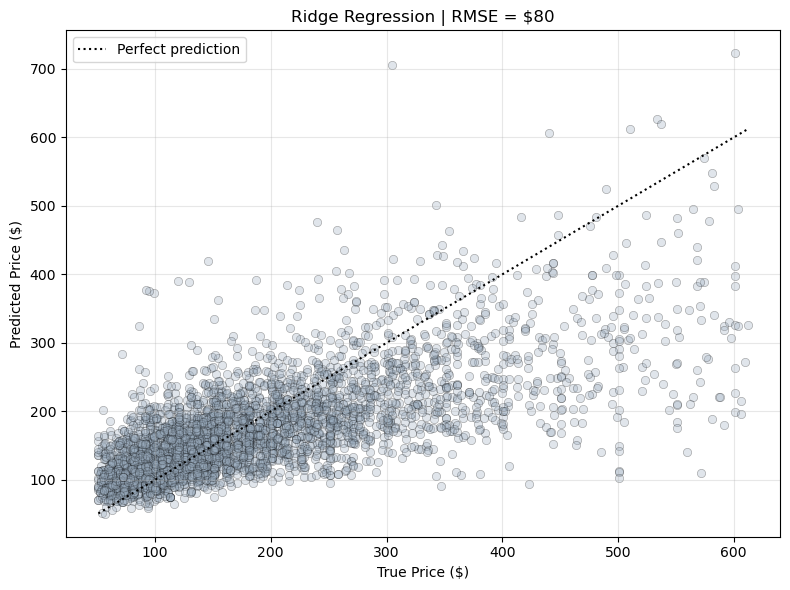


✅ Predictions stored with index: 1 to 41387


In [12]:
# Ridge CV
ridge_cv = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas=np.logspace(-3, 5, 100), cv=30, scoring='neg_mean_squared_error')
)

ridge_cv.fit(X_train, y_train)

# Check predictions before exp
y_pred_log = ridge_cv.predict(X_test)
print("y_pred before exp:", y_pred_log[:5])

y_pred = np.exp(y_pred_log)  
y_actual = np.exp(y_test) 

print("y_pred after exp:", y_pred[:5])
print("y_actual after exp:", y_actual[:5])

# Metrics
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f"\nRidge (α={ridge_cv.named_steps['ridgecv'].alpha_:.4f})")
print(f"MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f} | R²: {r2:.4f}")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred, alpha=0.3, color='#99ABBD', edgecolors='k', linewidth=0.5)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'k:', label='Perfect prediction')
plt.title(f"Ridge Regression | RMSE = ${rmse:,.0f}")
plt.xlabel("True Price ($)")
plt.ylabel("Predicted Price ($)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Store predictions in DataFrame (maintains index automatically)
val_predictions['ridge_cv'] = y_pred

print(f"\n✅ Predictions stored with index: {val_predictions.index.min()} to {val_predictions.index.max()}")



Random Forest (n=100)
MAE: $49.04 | RMSE: $73.35 | R²: 0.5717


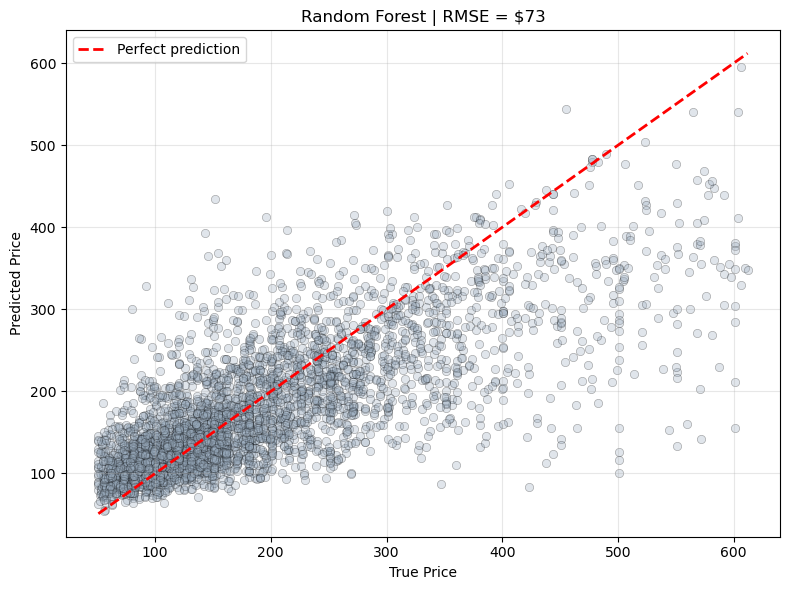

In [13]:
# Random Forest Regressor (Log Price)
forest = RandomForestRegressor(n_estimators=100, random_state=2, n_jobs=-1)
forest.fit(X_train, y_train)

# Predictions
y_pred_log = forest.predict(X_test)
y_pred = np.exp(y_pred_log)
y_actual = np.exp(y_test)

# Metrics
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f"\nRandom Forest (n=100)")
print(f"MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f} | R²: {r2:.4f}")

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_actual, y_pred, alpha=0.3, color='#99ABBD', edgecolors='k', linewidth=0.5)
ax.plot([y_actual.min(), y_actual.max()], 
        [y_actual.min(), y_actual.max()], 
        'r--', lw=2, label='Perfect prediction')

ax.set_title(f"Random Forest | RMSE = ${rmse:,.0f}")
ax.set_xlabel("True Price")
ax.set_ylabel("Predicted Price")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show() 
val_predictions['random_forest'] = y_pred


Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.3, 'max_depth': None}
Best CV RMSE (log): 0.3586

Random Forest CV (optimized)
MAE: $49.16 | RMSE: $73.52 | R²: 0.5698


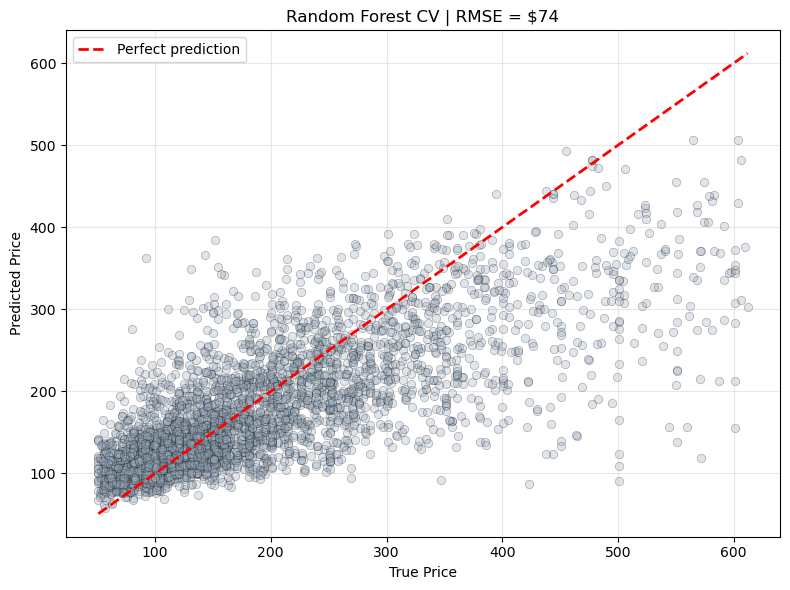

In [14]:
param_grid =  {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.3, 0.5]
}


forest_cv = RandomizedSearchCV(
    RandomForestRegressor(random_state=2, n_jobs=-1, bootstrap=True, oob_score=True),
    param_grid,
    n_iter=5,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=2
)

forest_cv.fit(X_train, y_train)

# Best parameters
print(f"\nBest params: {forest_cv.best_params_}")
print(f"Best CV RMSE (log): {np.sqrt(-forest_cv.best_score_):.4f}")

# Predictions
y_pred_log = forest_cv.predict(X_test)
y_pred = np.exp(y_pred_log)
y_actual = np.exp(y_test)

# Metrics
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f"\nRandom Forest CV (optimized)")
print(f"MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f} | R²: {r2:.4f}")

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_actual, y_pred, alpha=0.3, color='#99ABBD', edgecolors='k', linewidth=0.5)
ax.plot([y_actual.min(), y_actual.max()], 
        [y_actual.min(), y_actual.max()], 
        'r--', lw=2, label='Perfect prediction')

ax.set_title(f"Random Forest CV | RMSE = ${rmse:,.0f}")
ax.set_xlabel("True Price")
ax.set_ylabel("Predicted Price")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

val_predictions['random_forest_cv'] = y_pred



XGBoost (lr=0.2, n=1000)
MAE: $47.79 | RMSE: $71.76 | R²: 0.5902


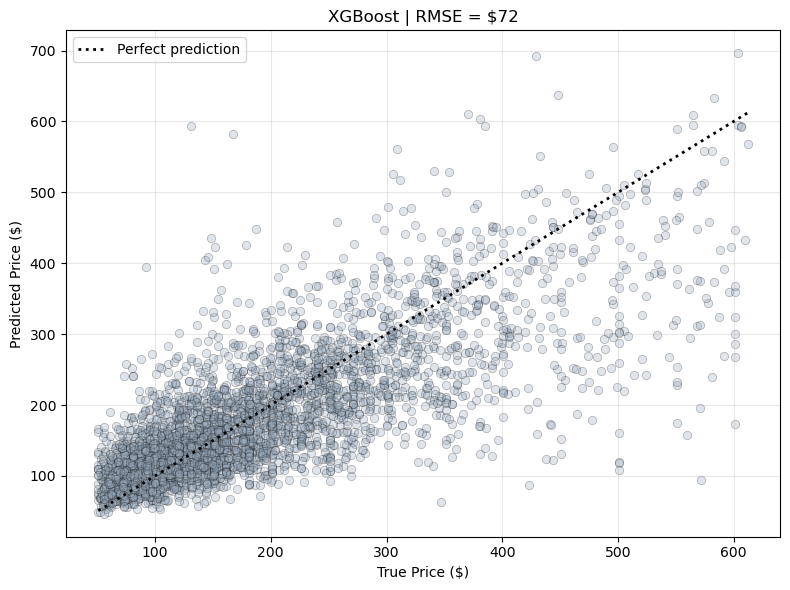

In [15]:
# XGBoost with log10-transformed prices
boost = XGBRegressor(learning_rate=0.2, n_estimators=1000, random_state=7)
boost.fit(X_train, y_train)

# Predict and convert back from log10
y_pred_log = boost.predict(X_test)
y_pred = np.exp(y_pred_log)  # Use 10^x for log10
y_actual = np.exp(y_test)    # Use 10^x for log10

# Metrics
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f"\nXGBoost (lr=0.2, n=1000)")
print(f"MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f} | R²: {r2:.4f}")

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_actual, y_pred, alpha=0.3, edgecolors='k', linewidth=0.5, color='#99ABBD')
ax.plot([y_actual.min(), y_actual.max()], 
        [y_actual.min(), y_actual.max()], 
        'k:', lw=2, label='Perfect prediction')

ax.set_title(f"XGBoost | RMSE = ${rmse:,.0f}")
ax.set_xlabel("True Price ($)")
ax.set_ylabel("Predicted Price ($)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

val_predictions['xgb'] = y_pred

Fitting 5 folds for each of 10 candidates, totalling 50 fits

XGBoost CV (optimized)
Best params: {'subsample': 0.9, 'reg_lambda': 12, 'reg_alpha': 0.15, 'n_estimators': 1000, 'min_child_weight': 15, 'max_depth': 6, 'learning_rate': 0.07, 'gamma': 0, 'colsample_bytree': 0.7}
MAE: $46.58 | RMSE: $69.36 | R²: 0.6171


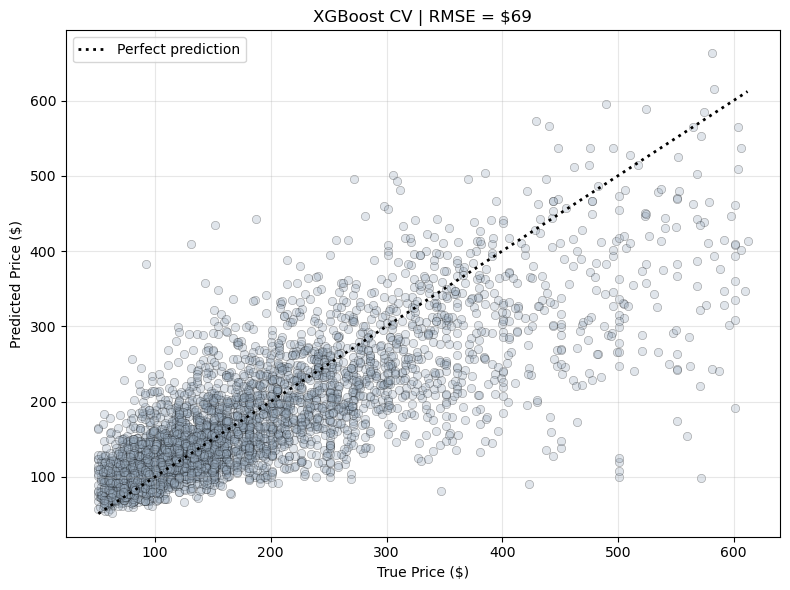

In [16]:
# XGBoost with RandomizedSearchCV (using existing log-transformed split)
param_grid = {
    # n_estimators: 900 was best, explore nearby with more trees
    'n_estimators': [850, 900, 950, 1000, 1100],
    
    # learning_rate: 0.08 was best, explore slightly higher/lower
    'learning_rate': [0.06, 0.07, 0.08, 0.085, 0.09],
    
    # max_depth: 6 was best, explore 5-7 range more finely
    'max_depth': [5, 6, 7],
    
    # min_child_weight: 20 was best, explore 15-30 range
    'min_child_weight': [15, 20, 25, 30],
    
    # subsample: 0.9 was best, explore 0.85-0.95
    'subsample': [0.85, 0.9, 0.95],
    
    # colsample_bytree: 0.7 was best, explore 0.65-0.8
    'colsample_bytree': [0.65, 0.7, 0.75, 0.8],
    
    # gamma: 0 was best, try small positive values
    'gamma': [0, 0.01, 0.05, 0.1],
    
    # reg_alpha: 0.1 was best, explore 0.05-0.2
    'reg_alpha': [0.05, 0.1, 0.15, 0.2],
    
    # reg_lambda: 10 was best, explore 8-15
    'reg_lambda': [8, 10, 12, 15]
}

xgb_cv = RandomizedSearchCV(
    XGBRegressor(random_state=7, n_jobs=-1, tree_method='hist', verbosity=0),
    param_grid,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=7,
    n_jobs=-1
)

# Fit on log-transformed data
xgb_cv.fit(X_train, y_train)

# Refit with early stopping
best_xgb = XGBRegressor(**xgb_cv.best_params_, random_state=7, n_jobs=-1, 
                        tree_method='hist', verbosity=0, early_stopping_rounds=50)
best_xgb.fit(X_train, y_train, 
             eval_set=[(X_test, y_test)], verbose=False)

# Predictions - convert from log10 back to actual prices
y_pred_log = best_xgb.predict(X_test)
y_pred = np.exp(y_pred_log)  # Use 10^x for log10
y_pred_bestxgb = y_pred
y_actual = np.exp(y_test)    # Use 10^x for log10

# Metrics
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f"\nXGBoost CV (optimized)")
print(f"Best params: {xgb_cv.best_params_}")
print(f"MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f} | R²: {r2:.4f}")

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_actual, y_pred, alpha=0.3, edgecolors='k', linewidth=0.5, color='#99ABBD')
ax.plot([y_actual.min(), y_actual.max()], 
        [y_actual.min(), y_actual.max()], 
        'k:', lw=2, label='Perfect prediction')

ax.set_title(f"XGBoost CV | RMSE = ${rmse:,.0f}")
ax.set_xlabel("True Price ($)")
ax.set_ylabel("Predicted Price ($)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

val_predictions['xgb_cv'] = y_pred


In [17]:
### Export with pickle ###
filename_airbnb_price = 'predict_airbnb_price.sav'
path = "/Users/aurelfalch/Library/Mobile Documents/com~apple~CloudDocs/01-Uni/03-Semester/04 Business Analytics und Data Science/Capstone/"
pickle.dump(best_xgb, open(path+filename_airbnb_price, 'wb') )

In [18]:
### load model to check if it worked ###
### DO NOT FORGET THAT THE RESULTS ARE STILL LOGGED!!###
loaded_model_airbnb_prices = pickle.load(open(path+filename_airbnb_price, 'rb'))
print(np.exp(loaded_model_airbnb_prices.predict(X_test_paris_dataset)))
print(y_pred_bestxgb)

### X should look like this####
print(X_test_paris_dataset.info())


[113.49281  120.7425   108.63582  ... 115.45803  100.112076 300.92383 ]
[113.49281  120.7425   108.63582  ... 115.45803  100.112076 300.92383 ]
<class 'pandas.core.frame.DataFrame'>
Index: 4140 entries, 6206 to 17067
Columns: 119 entries, host_is_superhost to host_identity_verified
dtypes: bool(26), float64(3), int64(90)
memory usage: 3.1 MB
None


### Ensemble optimization - not relevant for Webapp
Creating an ensemble of all different models by giving them certain weights

We can't use it as a model for the webapp (we can not give it X to get y)

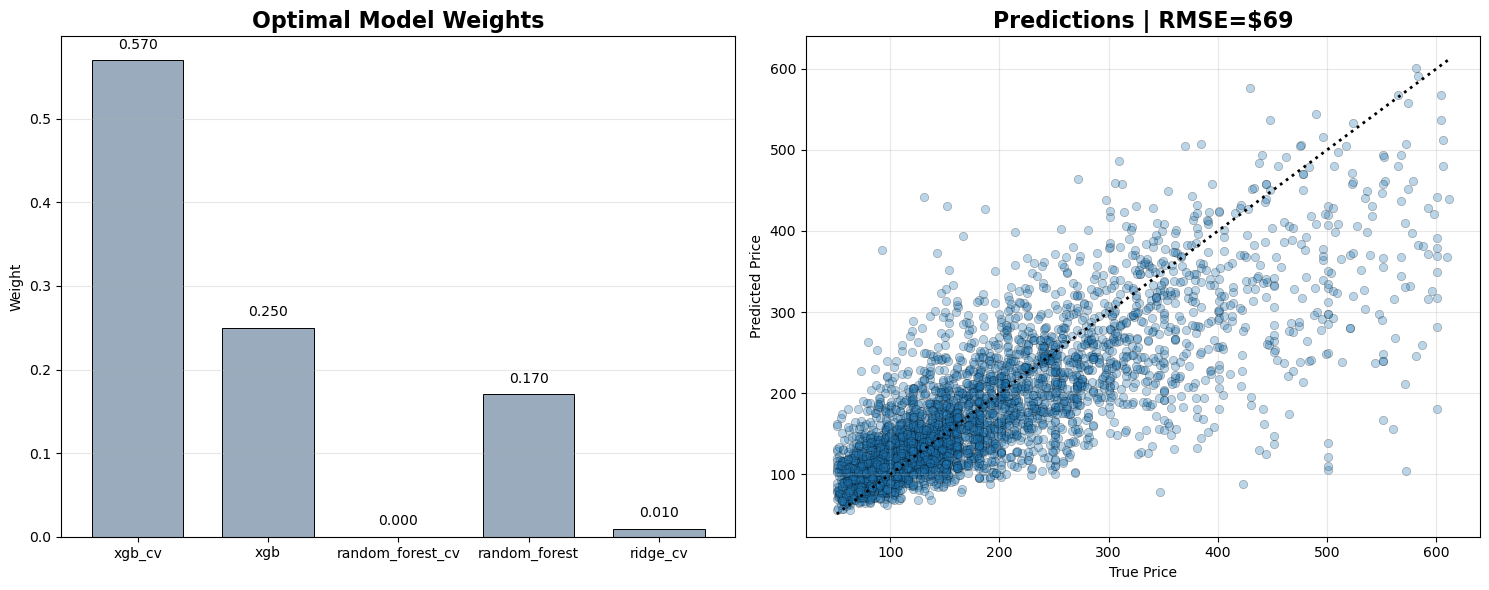

{'MAE': 46.072461907015125, 'RMSE': np.float64(68.79234667115817), 'R²': 0.6233395925121344}

Prediction DataFrame created with shape: (4140, 2)
       predicted_price  actual_price
6206        112.388176         119.0
33056       121.642360          82.0
21553       112.996982         106.0
12296        84.297143          53.0
13993       266.948939         304.0


In [19]:
# ENSEMBLE OPTIMIZATION FOR FINDING ACCURATE WEIGHTS 

# Prepare data
val_predictions['actual'] = y_actual
model_names = ['xgb_cv', 'xgb', 'random_forest_cv', 'random_forest', 'ridge_cv']
pred_matrix = np.column_stack([val_predictions[name] for name in model_names])
y_true = val_predictions['actual']

# Optimize weights
result = minimize(
    lambda w: np.sqrt(mean_squared_error(y_true, pred_matrix @ w)),
    np.ones(len(model_names)) / len(model_names),
    method='SLSQP',
    bounds=[(0, 1)] * len(model_names),
    constraints={'type': 'eq', 'fun': lambda w: w.sum() - 1}
)
weights = result.x

# Evaluate
ensemble_pred = pred_matrix @ weights
metrics = {
    'MAE': mean_absolute_error(y_true, ensemble_pred),
    'RMSE': np.sqrt(mean_squared_error(y_true, ensemble_pred)),
    'R²': r2_score(y_true, ensemble_pred)
}

# AFTER (force it):
prediction = pd.DataFrame({
    'predicted_price': ensemble_pred,
    'actual_price': y_true
})
prediction.index = X_test.index
# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.bar(model_names, weights, color='#99ABBD', edgecolor='black',linewidth=0.7, width=0.7)
ax1.set_title('Optimal Model Weights', fontsize=16, fontweight='bold')
ax1.set_ylabel('Weight')
ax1.grid(axis='y', alpha=0.3)
for i, w in enumerate(weights):
    ax1.text(i, w + 0.01, f'{w:.3f}', ha='center', va='bottom')

ax2.scatter(y_true, ensemble_pred, alpha=0.3, edgecolors='k', linewidth=0.5)
ax2.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k:', lw=2)
ax2.set_title(f'Predictions | RMSE=${metrics["RMSE"]:,.0f}', fontsize=16, fontweight='bold')
ax2.set_xlabel('True Price')
ax2.set_ylabel('Predicted Price')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(metrics)
print(f"\nPrediction DataFrame created with shape: {prediction.shape}")
print(prediction.head())


In [20]:
# Get arrondissement columns from X_test
arrondissement_cols = [col for col in X_test.columns if col.startswith('Arrondissement_')]

# Extract arrondissement number from the dummy columns
# Find which arrondissement column is True (1) for each row
arrondissement = X_test[arrondissement_cols].idxmax(axis=1).str.extract('(\d+|1er)')[0]

# Convert '1er' to '1' and make numeric
arrondissement = arrondissement.replace('1er', '1').astype(int)

# Add to prediction DataFrame (using .loc to ensure proper alignment)
prediction['arrondissement'] = arrondissement.values

# Display result
print("Prediction DataFrame with Arrondissement:")
print(prediction.head(10))
print(f"\nShape: {prediction.shape}")
print(f"\nColumns: {prediction.columns.tolist()}")
print(f"\nArrondissements in test set: {sorted(prediction['arrondissement'].unique())}")
print(f"\nCount by Arrondissement:")
print(prediction['arrondissement'].value_counts().sort_index())


Prediction DataFrame with Arrondissement:
       predicted_price  actual_price  arrondissement
6206        112.388176         119.0              19
33056       121.642360          82.0              16
21553       112.996982         106.0              20
12296        84.297143          53.0              10
13993       266.948939         304.0              15
5040        191.129763         217.0               9
8768        161.960427         167.0              10
20066       249.628090         190.0              18
22801       299.110294         270.0               6
323          91.324614          61.0              20

Shape: (4140, 3)

Columns: ['predicted_price', 'actual_price', 'arrondissement']

Arrondissements in test set: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.in

### These Models are predicting the average rent (no airbnb) based on the number of rooms
The following dataset gives us the rental price per arrondissement (per m2)

In [21]:
Renting=pd.read_csv('/Users/aurelfalch/Library/Mobile Documents/com~apple~CloudDocs/01-Uni/03-Semester/04 Business Analytics und Data Science/Capstone/data/Loyer encadré paris.csv')
Renting['Arrondissement'] = Renting['Nom du quartier'].map(quartier_to_arrondissement)
Renting.dtypes
Renting = pd.get_dummies(Renting,
                               columns=['Arrondissement', 'Type de location'],
                               prefix=['Arrondissement', 'Type de locationom'],
                               drop_first=False)
display(Renting)


,Année,Secteurs géographiques,Numéro du quartier,Nom du quartier,Nombre de pièces principales,Epoque de construction,Loyers de référence,Loyers de référence majorés,Loyers de référence minorés,Arrondissement_10e,...,Arrondissement_2e,Arrondissement_3e,Arrondissement_4e,Arrondissement_5e,Arrondissement_6e,Arrondissement_7e,Arrondissement_8e,Arrondissement_9e,Type de locationom_meublé,Type de locationom_non meublé
0,2024,11,39,Porte-Saint-Martin,3,Apres 1990,25.5,30.6,17.9,True,...,False,False,False,False,False,False,False,False,True,False
1,2024,14,47,Bercy,1,1946-1970,28.8,34.6,20.2,False,...,False,False,False,False,False,False,False,False,True,False
2,2025,2,34,Chaussée-d'Antin,2,1946-1970,28.5,34.2,20.0,False,...,False,False,False,False,False,False,False,True,False,True
3,2025,1,23,Notre-Dame-des-Champs,3,Apres 1990,30.2,36.2,21.1,False,...,False,False,False,False,True,False,False,False,False,True
4,2023,3,62,Muette,4,Apres 1990,29.3,35.2,20.5,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17915,2023,14,79,Père-Lachaise,4,Avant 1946,22.6,27.1,15.8,False,...,False,False,False,False,False,False,False,False,True,False
17916,2023,6,65,Ternes,2,Avant 1946,27.0,32.4,18.9,False,...,False,False,False,False,False,False,False,False,False,True
17917,2023,4,6,Vivienne,3,Avant 1946,29.2,35.0,20.4,False,...,True,False,False,False,False,False,False,False,True,False
17918,2025,1,28,Gros-Caillou,4,Apres 1990,35.9,43.1,25.1,False,...,False,False,False,False,False,True,False,False,True,False


This Regression takes the number of rooms to calculate the Living Area in m2.

R² Score: 0.8235


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


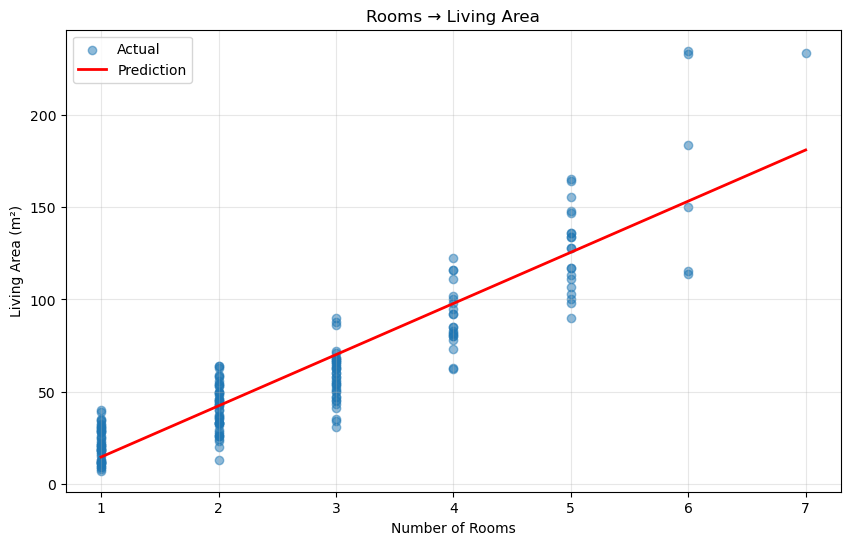

In [22]:
# Load and prepare data
Kaggle_m_to_room = pd.read_csv('/Users/aurelfalch/Library/Mobile Documents/com~apple~CloudDocs/01-Uni/03-Semester/04 Business Analytics und Data Science/Capstone/data/kaggle dataset m^2--nb rooms.csv')

Kaggle_m_to_room['Living_numeric'] = Kaggle_m_to_room['Living'].str.replace(' m²', '').str.replace(',', '.').astype(float)
df_clean = Kaggle_m_to_room[['Living_numeric', 'Rooms']].dropna()

# Train model: Rooms → Living Area
X = df_clean[['Rooms']]
y = df_clean['Living_numeric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_room_to_m = LinearRegression()
model_room_to_m.fit(X_train, y_train)
y_pred = model_room_to_m.predict(X_test)

# R² Score
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, alpha=0.5, label='Actual')
X_range = np.linspace(X_test.min(), X_test.max(), 300).reshape(-1, 1)
plt.plot(X_range, model_room_to_m.predict(X_range), 'r-', linewidth=2, label='Prediction')
plt.xlabel('Number of Rooms')
plt.ylabel('Living Area (m²)')
plt.title('Rooms → Living Area')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Prediction of the Price depending on if the appartement is furnished or not
Try to find a good way to show the revenue when the appartement is furnished and when its not furnished. (Type de locationom_meublé)

For this regression a Random Forest is used

In [23]:
# Add size in m² using the model
Renting['m²'] = model_room_to_m.predict(Renting[['Nombre de pièces principales']].rename(columns={'Nombre de pièces principales': 'Rooms'}))

# Add monthly rent (m² * rent per m²)
Renting['Monthly Rent'] = Renting['m²'] * Renting['Loyers de référence']


y_Renting=Renting['Monthly Rent']
X_Renting=Renting.drop(['Monthly Rent', 'Nom du quartier','m²','Loyers de référence','Loyers de référence majorés','Loyers de référence minorés','Epoque de construction',
                        'Secteurs géographiques','Numéro du quartier','Nom du quartier','Année'], axis=1)
display(X_Renting)
display(y_Renting)

X_train_Renting, X_test_Renting, y_train_Renting, y_test_Renting = train_test_split(
    X_Renting, y_Renting, test_size=0.1, random_state=42)

y_test_Renting.mean()

X_test_Renting_pred_pickle = X_test_Renting

,Nombre de pièces principales,Arrondissement_10e,Arrondissement_11e,Arrondissement_12e,Arrondissement_13e,Arrondissement_14e,Arrondissement_15e,Arrondissement_16e,Arrondissement_17e,Arrondissement_18e,...,Arrondissement_2e,Arrondissement_3e,Arrondissement_4e,Arrondissement_5e,Arrondissement_6e,Arrondissement_7e,Arrondissement_8e,Arrondissement_9e,Type de locationom_meublé,Type de locationom_non meublé
0,3,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,1,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,2,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
3,3,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
4,4,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17915,4,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
17916,2,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
17917,3,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
17918,4,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False


0        1785.297094
1         416.329677
2        1203.662478
3        2114.351853
4        2865.233239
            ...     
17915    2210.043386
17916    1140.311821
17917    2044.340202
17918    3510.644139
17919    1926.453748
Name: Monthly Rent, Length: 17920, dtype: float64


Random Forest (n=100)
MAE: $93.83 | RMSE: $132.90 | R²: 0.9696


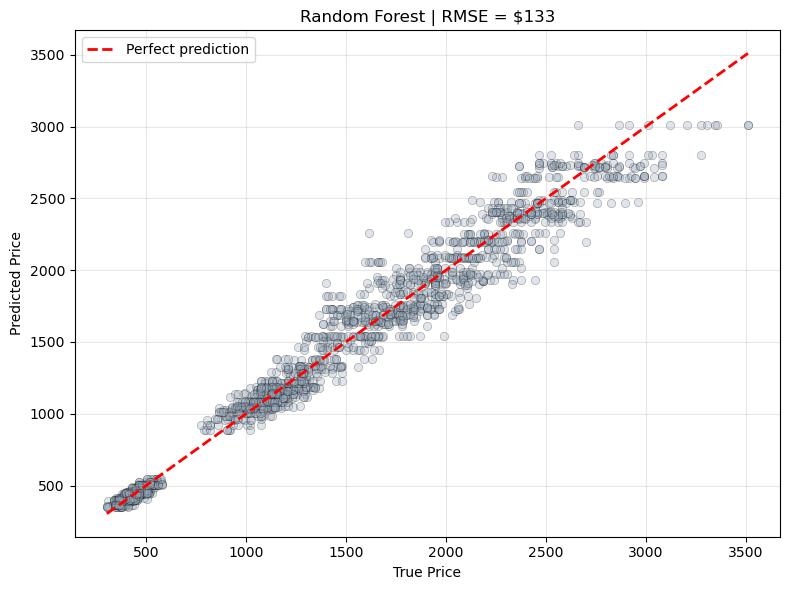

In [24]:
# Random Forest Regressor (Log Price)
forest = RandomForestRegressor(n_estimators=100, random_state=2, n_jobs=-1)
forest.fit(X_train_Renting, y_train_Renting)

# Predictions
y_pred = forest.predict(X_test_Renting)
y_pred_renting = y_pred
y_actual = (y_test_Renting)

# Metrics
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print(f"\nRandom Forest (n=100)")
print(f"MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f} | R²: {r2:.4f}")

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_actual, y_pred, alpha=0.3, color='#99ABBD', edgecolors='k', linewidth=0.5)
ax.plot([y_actual.min(), y_actual.max()], 
        [y_actual.min(), y_actual.max()], 
        'r--', lw=2, label='Perfect prediction')

ax.set_title(f"Random Forest | RMSE = ${rmse:,.0f}")
ax.set_xlabel("True Price")
ax.set_ylabel("Predicted Price")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show() 

In [25]:
### Export with pickle ###
### Here you need to create a new X Dataframe including the number of rooms and if it is furnished or not!!
filename_renting_price = 'predict_renting_price.sav'
path = "/Users/aurelfalch/Library/Mobile Documents/com~apple~CloudDocs/01-Uni/03-Semester/04 Business Analytics und Data Science/Capstone/"
pickle.dump(forest, open(path+filename_renting_price, 'wb') )

In [26]:
### load model to check if it worked ###
loaded_model_renting_prices = pickle.load(open(path+filename_renting_price, 'rb'))
print(loaded_model_renting_prices.predict(X_test_Renting_pred_pickle))
print(y_pred_renting)

### X should look like this###
print(X_test_Renting_pred_pickle.info())


[1326.95215234  390.50814048 2144.22279012 ... 1686.84175073  366.72540949
  441.08199812]
[1326.95215234  390.50814048 2144.22279012 ... 1686.84175073  366.72540949
  441.08199812]
<class 'pandas.core.frame.DataFrame'>
Index: 1792 entries, 12493 to 9531
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Nombre de pièces principales   1792 non-null   int64
 1   Arrondissement_10e             1792 non-null   bool 
 2   Arrondissement_11e             1792 non-null   bool 
 3   Arrondissement_12e             1792 non-null   bool 
 4   Arrondissement_13e             1792 non-null   bool 
 5   Arrondissement_14e             1792 non-null   bool 
 6   Arrondissement_15e             1792 non-null   bool 
 7   Arrondissement_16e             1792 non-null   bool 
 8   Arrondissement_17e             1792 non-null   bool 
 9   Arrondissement_18e             1792 non-null   bool 
 10  Arrondissem

In [27]:
display(Paris_encoded[['bedrooms','bathrooms_text']])
# Check what columns your training data actually has


,bedrooms,bathrooms_text
0,1.0,1.0
1,0.0,1.0
2,2.0,1.0
3,1.0,1.0
4,2.0,1.0
...,...,...
41388,1.0,1.0
41389,3.0,1.0
41390,1.0,1.0
41391,1.0,1.0


### Linear Regression for Cleaning Costs
This linear Regression gives us the Cost of one cleaning given the number of rooms and number of bathrooms

For the prediction of the monthly cleaning costs we take the average length of stay in an airbnb is 4.8 days as given.
https://airbtics.com/tourism-statistics-paris-fr/

30/4.8 = 6,25 Cleanings per month

array([5.60344828, 6.10344828])

np.float64(20.051724137931025)

,bedrooms,bathrooms_text,reviews_per_month,cleaning_price_per_month
0,1.0,1.0,0.08,41.159172
1,0.0,1.0,2.32,104.202207
2,2.0,1.0,2.20,143.470345
3,1.0,1.0,0.35,51.448966
4,2.0,1.0,0.86,83.392138
...,...,...,...,...
41388,1.0,1.0,0.00,38.110345
41389,3.0,1.0,0.00,51.558621
41390,1.0,1.0,0.00,38.110345
41391,1.0,1.0,0.00,38.110345


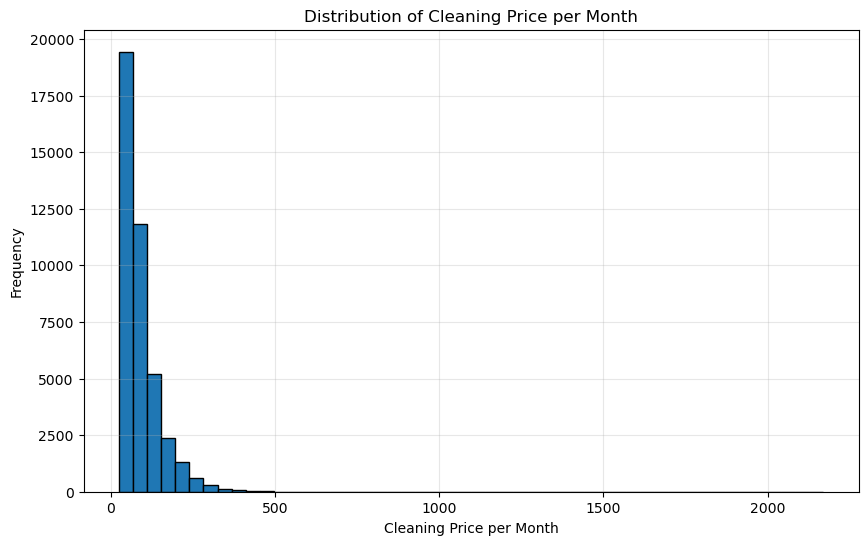

count    41393.000000
mean        89.019692
std         61.317313
min         24.062069
25%         48.781241
50%         70.305103
75%        108.614483
max       2170.003862
Name: cleaning_price_per_month, dtype: float64

In [28]:
from sklearn.linear_model import LinearRegression

data = pd.read_csv('/Users/aurelfalch/Library/Mobile Documents/com~apple~CloudDocs/01-Uni/03-Semester/04 Business Analytics und Data Science/Capstone/data/RoomDataK.csv', sep=';', decimal=',')

X_cleaning_cost = data.drop(['Price'], axis=1)
y_cleaning_cost = data['Price']

linreg = LinearRegression().fit(X_cleaning_cost, y_cleaning_cost)
display(linreg.coef_)
display(linreg.intercept_)

# Create a temporary dataframe with the correct column names for prediction
Paris_predict = Paris_encoded[['bedrooms', 'bathrooms_text']].copy()
Paris_predict.columns = ['Bedroom', 'Bathroom']  # Rename to match training data

# Now predict
Paris_encoded['cleaning_price_per_month'] = (
    linreg.predict(Paris_predict) * 
    ((Paris_encoded['reviews_per_month']+1))*1.2
)

display(Paris_encoded[['bedrooms', 'bathrooms_text', 'reviews_per_month', 'cleaning_price_per_month']])

plt.figure(figsize=(10, 6))
plt.hist(Paris_encoded['cleaning_price_per_month'].dropna(), bins=50, edgecolor='black')
plt.xlabel('Cleaning Price per Month')
plt.ylabel('Frequency')
plt.title('Distribution of Cleaning Price per Month')
plt.grid(True, alpha=0.3)
plt.show()
Paris_encoded['cleaning_price_per_month'].describe()


In [29]:
### Export with pickle ###
### Here you need to create a new X Dataframe including the number of rooms and if it is furnished or not!!
filename_cleaning = 'predict_cost_of_cleaning.sav'
path = "/Users/aurelfalch/Library/Mobile Documents/com~apple~CloudDocs/01-Uni/03-Semester/04 Business Analytics und Data Science/Capstone/"
pickle.dump(linreg, open(path+filename_cleaning, 'wb') )

In [30]:
### load model to check if it worked ###
loaded_model_cleaning = pickle.load(open(path+filename_cleaning, 'rb'))
print(loaded_model_cleaning.predict(X_cleaning_cost))

### X should look like this###
print(X_cleaning_cost.info())


[31.75862069 37.36206897 37.86206897 43.46551724 49.06896552 49.56896552
 60.77586207 66.87931034 72.48275862 78.0862069  83.68965517]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Bedroom   11 non-null     int64
 1   Bathroom  11 non-null     int64
dtypes: int64(2)
memory usage: 308.0 bytes
None


### Occupancy in percent
Calculate the monthly airbnb revenue with the occupancy rates in the csv (scraped it from this website: 
https://www.airroi.com/atlas/map/?country-code=FR&state=Ile\-de\-France&city=Paris&neighborhood=1st-Arrondissement )



In [31]:
occupancy_rate=pd.read_csv('/Users/aurelfalch/Library/Mobile Documents/com~apple~CloudDocs/01-Uni/03-Semester/04 Business Analytics und Data Science/Capstone/data/occupancy_arrondissement.csv', sep=';')
display(occupancy_rate)

,Arrondissement,Occupancy in percent
0,1,58
1,2,58
2,3,57
3,4,57
4,5,57
5,6,54
6,7,54
7,8,54
8,9,54
9,10,56
